In [118]:
import torch
from torch.autograd.function import InplaceFunction, Function
import torch.nn as nn
from torch.nn import Linear, Conv2d
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [119]:
# Training configs
batch_size = 64
bitw_forward = 32
bitf_forward = 12

bitw_backward = 64
bitf_backward = 20

re_scale = False

use_LN = False

log_acc = True
quant = True
w_linear = True
w_conv = True

# SecureML, MiniONN, LeNet, AlexNet, VGG16
model_name = "VGG16"

shifting_scale = 1.

# ds = 'CIFAR-10'
ds = 'CIFAR-10' if model_name in ['AlexNet', 'VGG16'] else 'MNIST'

verbose = True

"""
make sure all the random initiation of parameters are the same in different runs
"""
torch.manual_seed(0)
# print(torch.rand(2,3))

## Customized Quantized Function

In [120]:
def overflow_validate(val, bitw, location):
    if val.abs().max() >= float(2**(bitw-1)):
        raise Exception("Overflow {4}! Val: {0}, Bit-width: {1}, val: [-{2}, {3}]".format(val.abs().max(), bitw, 1 << (bitw-1), (1 << (bitw-1)) - 1, location))

class FxInput(InplaceFunction):
    """
    Quantize w.r.t. qmax in forward pass; use STE in backward pass
    """
    @staticmethod
    def forward(ctx, input, bitw_forward, bitw_backward, bitf_forward, bitf_backward, inplace=False, trunc=False):
        ctx.inplace = inplace
        if ctx.inplace:
            ctx.mark_dirty(input)
            output = input

        else:
            output = input.clone()

        # def overflow_validate(val, bitw):
        #     if val.abs().max() >= float(2**(bitw-1)):
        #         raise Exception("Overflow FxInput forward! Val: {0}, Bit-width: {1}, val: {2}".format(val.max(), bitw, 1 << bitw))

        if trunc:   # 2f-bit precision, require truncation by 2^f
            output = (output * (1 << bitf_backward)).floor()
            overflow_validate(output, bitw_backward, "FxInput forward")
            output = (output / (1 << (bitf_backward - bitf_forward))).floor()     # FX-representation
            overflow_validate(output, bitw_forward, "FxInput forward")
            output = output / (1 << bitf_forward)                         # translate to FP
            # if output.max() >= (1 << (bitw - bitf_after)):                                 # overflow judgement
            #     print("overflow")
        else:       # 0-bit precision, require multiply by 2^f, currently not used
            output = (output * (1 << bitf_forward)).floor()              # FX-representation
            overflow_validate(output, bitw_forward, 'FxInput forward')
            output = output / (1 << bitf_backward)                         # FP
            # if output.max() >= (1 << (bitw - bitf_before)):                                 # overflow judgement
            #     print("overflow")
        return output
    
    """
    Follow the STE method. Such that the gradient of Quant(x) is 1
    """
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output
        return grad_input, None, None, None, None, None, None

class FxLinear(Function):
    """
    FX multiplication for linear layers. Difference is the backward gradients shall be truncated by 2^f as well
    input: (32, 10)
    weight: (64, 16)
    bias: (64, 16)
    """
    @staticmethod
    def forward(ctx, input, weight, bias, bitw_forward, bitf_forward, bitw_backward, bitf_backward):
        with torch.enable_grad():
            detached_input = input.detach()
            detached_input.requires_grad_(True)

            detached_weight = weight.detach()
            detached_weight.requires_grad_(True)

            detached_bias = bias.detach()
            detached_bias.requires_grad_(True)
            """
            7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
            """

            qweight = FxInput.apply(detached_weight, bitw_forward, bitw_backward, bitf_forward, bitf_backward, False, True) # FX32 weight, should be truncated by (16 - 10) bits
            qbias = FxInput.apply(detached_bias, bitw_forward, bitw_backward, bitf_forward, bitf_backward, False, True) # FX32 weight, should be truncated by (16 - 10) bits


            """
            Print histogram of weights before and after quantization
            """
            if not verbose:
                n, bins, patches = plt.hist(detached_weight.data, 50)
                plt.show()

                n, bins, patches = plt.hist(qweight.data, 50)
                plt.show()
            

            _output = F.linear(detached_input, qweight, qbias)

        ctx.saved_input = detached_input
        ctx.saved_param = detached_weight, detached_bias
        ctx.bits = bitw_forward, bitf_forward, bitw_backward, bitf_backward
        ctx.save_for_backward(_output)

        # trunc after multiplication
        output = (_output.detach() *(1 << (2*bitf_forward))).floor()            # FX

        overflow_validate(output, bitw_forward, 'Linear Forward')
        # if output.abs().max() >= float(2**(bitw_forward-1)):
        #     raise Exception("Overflow Linear Forward! Val: {0}, Bit-width: {1}".format(output.max(), bitw_forward))

        output = (output / (1 << bitf_forward)).floor()                         # FX Trunc
        output = output / (1 << bitf_forward)                                   # FP
        return output

    @staticmethod
    def backward(ctx, grad_output):
        _output, = ctx.saved_tensors
        """
        grad_output: (64, 16), nothing should be done
        grad_param (input, weight, bias): (64, 16) * (32, 10), should be extended. Here, only left-shift by (bitf_backward - bitf_forward) is required.
        weights: forward + backward, Here, since the backward-precision weight is kept, we can directly perform right-shift.
        """
        _weight, _bias = ctx.saved_param
        _input = ctx.saved_input
        # print("grad_output: ", grad_output)
        # grad_output.data = torch.tensor(7.6875)

        # TODO: this actually should be modified, since 64-bit * 32-bit cannot be directly multiplied. Here, i use FP thus the computation can be carried out, despite the precision
        with torch.enable_grad():
            _output.backward(grad_output)

        """
        (qweight)122 * 123 (4-bit) --> 15006 --> 937 --> 58.5625
        7.625 * 7.6875 --> 58.6171875 --> 7503 --> trunc --> 937
        7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
        """
        grad_weight, grad_bias = _weight.grad, _bias.grad   # backward
        grad_input = _input.grad
        # print("ss: ", grad_input)

        bitw_forward, bitf_forward, bitw_backward, bitf_backward = ctx.bits

        # def overflow_validate(val, bitw):
        #     if val.abs().max() >= float(2**(bitw-1)):
        #         raise Exception("Overflow Linear Backward! Val: {0}, Bit-width: {1}".format(val.max(), bitw))

        grad_weight = (grad_weight * (1 << (bitf_forward + bitf_backward))).floor()     #FX
        overflow_validate(grad_weight, bitw_backward, 'Linear Backward Weight')
        grad_weight = (grad_weight / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        grad_bias = (grad_bias * (1 << (bitf_forward + bitf_backward))).floor()         #FX
        overflow_validate(grad_bias, bitw_backward, 'Linear Backward Bias')
        grad_bias = (grad_bias / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        grad_input = (grad_input * (1 << (bitf_forward + bitf_backward))).floor()       #FX
        overflow_validate(grad_input, bitw_backward, 'Linear Backward Activation')
        grad_input = (grad_input / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        return grad_input, grad_weight, grad_bias, None, None, None, None

class FxConv2D(Function):
    """
    FX Convolution for linear layers. Difference is the backward gradients shall be truncated by 2^f as well
    input: (32, 10)
    weight: (64, 16)
    bias: (64, 16)
    """
    @staticmethod
    def forward(ctx, input, weight, bias, stride, padding, dilation, groups, bitw_forward, bitf_forward, bitw_backward, bitf_backward):
        with torch.enable_grad():
            detached_input = input.detach()
            detached_input.requires_grad_(True)

            detached_weight = weight.detach()
            detached_weight.requires_grad_(True)

            detached_bias = bias.detach()
            detached_bias.requires_grad_(True)
            """
            7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
            """
            qweight = FxInput.apply(detached_weight, bitw_forward, bitw_backward, bitf_forward, bitf_backward, False, True) # FX32 weight, should be truncated by (16 - 10) bits
            qbias = FxInput.apply(detached_bias, bitw_forward, bitw_backward, bitf_forward, bitf_backward, False, True) # FX32 weight, should be truncated by (16 - 10) bits
            
            _output = F.conv2d(detached_input, qweight, qbias, stride, padding, dilation, groups)

        ctx.saved_input = detached_input
        ctx.saved_param = detached_weight, detached_bias
        ctx.bits = bitw_forward, bitf_forward, bitw_backward, bitf_backward

        ctx.save_for_backward(_output)

        # trunc after multiplication
        output = (_output.detach() * (1 << (2*bitf_forward))).floor()           # FX

        overflow_validate(output, bitw_forward, 'Conv2D Forward')
        # if output.abs().max() >= float(2**(bitw_forward-1)):
        #     raise Exception("Overflow Conv2D Forward! Val: {0}, Bit-width: {1}, val: {2}".format(output.max(), bitw_forward, 1 << bitw_forward))
            
        output = (output / (1 << bitf_forward)).floor()                         # FX truncate by bitf_forward bits
        output = output / (1 << bitf_forward)                                   # FP
        return output

    @staticmethod
    def backward(ctx, grad_output):
        _output, = ctx.saved_tensors
        """
        grad_output: (64, 16), nothing should be done
        grad_param (input, weight, bias): (64, 16) * (32, 10), should be extended. Here, only left-shift by (bitf_backward - bitf_forward) is required.
        weights: forward + backward, Here, since the backward-precision weight is kept, we can directly perform right-shift.
        """
        _weight, _bias = ctx.saved_param
        _input = ctx.saved_input
        # print("grad_output: ", grad_output)
        # grad_output.data = torch.tensor(7.6875)

        # TODO: this actually should be modified, since 64-bit * 32-bit cannot be directly multiplied. Here, i use FP thus the computation can be carried out, despite the precision
        with torch.enable_grad():
            _output.backward(grad_output)

        """
        (qweight)122 * 123 (4-bit) --> 15006 --> 937 --> 58.5625
        7.625 * 7.6875 --> 58.6171875 --> 7503 --> trunc --> 937
        7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
        """
        grad_weight, grad_bias = _weight.grad, _bias.grad   # backward
        grad_input = _input.grad

        bitw_forward, bitf_forward, bitw_backward, bitf_backward = ctx.bits

        # def overflow_validate(val, bitw):
        #     if val.abs().max() >= float(2**(bitw-1)):
        #         raise Exception("Overflow Conv2D Backward! Val: {0}, Bit-width: {1}, ring: {2}".format(val.max(), bitw, 1 << bitw))

        grad_weight = (grad_weight * (1 << (bitf_forward + bitf_backward))).floor()     #FX
        overflow_validate(grad_weight, bitw_backward, 'Conv2D Backward Weight')
        grad_weight = (grad_weight / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        grad_bias = (grad_bias * (1 << (bitf_forward + bitf_backward))).floor()         #FX
        overflow_validate(grad_bias, bitw_backward, 'Conv2D Backward Bias')
        grad_bias = (grad_bias / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        grad_input = (grad_input * (1 << (bitf_forward + bitf_backward))).floor()       #FX
        overflow_validate(grad_input, bitw_backward, 'Conv2D Backward Activation')
        grad_input = (grad_input / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        return grad_input, grad_weight, grad_bias, None, None, None, None, None, None, None, None

class FxLayerNorm(Function):
    """
    FX LayerNorm for normalization activation outputs.
    """
    @staticmethod
    def fx_mean(input, bitw_forward, bitw_backward, bitf_forward, bitf_backward):
        tar_mean = input.mean(-1, keepdim = True)

        # fx mean imp
        sum = input.sum(-1, keepdim = True)
        divisor = input.shape[-1]
        recp = torch.tensor(((1. / divisor) * (1 << bitf_forward))).floor() / (1 << bitf_forward)      # TODO: here should use godsmich to approximate the recp, which may incur additional precision loss
        mean = sum * recp

        # Fx --> Fp
        mean_fx = (mean * (1 << (2 * bitf_forward))).floor()
        mean = (mean_fx / (1 << bitf_forward)).floor() / (1 << bitf_forward)

        # definitely not overflow, so here pass the overflow validate

        # print("tar mean: {0}, output_mean: {1}, diff: {2}".format(tar_mean, mean, mean - tar_mean))
        return mean

    @staticmethod
    def fx_var(input, bitw_forward, bitw_backward, bitf_forward, bitf_backward):
        tar_var = input.var(-1, keepdim = True)

        # fx var imp
        mean = FxLayerNorm.fx_mean(input, bitw_forward, bitw_backward, bitf_forward, bitf_backward)
        diff = (input - mean)
        diff = diff ** 2
        diff_sum = diff.sum(-1, keepdim = True)
        diff_sum = (diff_sum * (1 << (2*bitf_forward))).floor()
        overflow_validate(diff_sum, bitw_forward, "FX Variance")

        diff_sum = (diff_sum / (1 << bitf_forward)).floor() / (1 << bitf_forward)


        divisor = input.shape[-1]
        recp = torch.tensor(((1. / divisor) * (1 << bitf_forward))).floor() / (1 << bitf_forward)       # TODO: here should use godsmich to approximate the recp, which may incur additional precision loss
        var = diff_sum * recp

        # Fx --> Fp
        var_fx = (var * (1 << (2 * bitf_forward))).floor()
        var = (var_fx / (1 << bitf_forward)).floor() / (1 << bitf_forward)

        # print("tar var: {0}, output var: {1}, diff: {2}".format(tar_var, var, var - tar_var))
        return mean, var

    @staticmethod
    def fx_layer_norm(input, bitw_forward, bitw_backward, bitf_forward, bitf_backward):
        mean, var = FxLayerNorm.fx_var(input, bitw_forward, bitw_backward, bitf_forward, bitf_backward)

        dividend = input - mean

        divisor = torch.sqrt(var)
        recp = torch.tensor(((1. / divisor) * (1 << bitf_forward))).floor() / (1 << bitf_forward)       # TODO: here should use godsmich to approximate the recp, which may incur additional precision loss
        
        norm_output = dividend * recp
        return norm_output


    @staticmethod
    def forward(ctx, input, bitw_forward, bitf_forward, bitw_backward, bitf_backward):
        with torch.enable_grad():
            detached_input = input.detach()
            detached_input.requires_grad_(True)
            print(detached_input)
            fx_output = FxLayerNorm.fx_layer_norm(detached_input, bitw_forward, bitw_backward, bitf_forward, bitf_backward)
            
            _output = F.layer_norm(detached_input, (detached_input.shape[-1],))

            print("tar norm: {0}, output norm: {1}, diff: {2}".format(_output, fx_output, fx_output - _output))
        
        ctx.saved_input = detached_input
        ctx.bits = bitw_forward, bitf_forward, bitw_backward, bitf_backward
        ctx.save_for_backward(_output)

        # trunc after multiplication
        output = (_output.detach() *(1 << (2*bitf_forward))).floor()            # FX
        print(output)

        overflow_validate(output, bitw_forward, 'LayerNorm Forward')
        # if output.abs().max() >= 2 **(bitw_forward-1):
        #     raise Exception("Overflow! Val: {0}, Bit-width: {1}".format(output.max(), bitw_forward))

        output = (output / (1 << bitf_forward)).floor()                         # FX Trunc
        output = output / (1 << bitf_forward)                                   # FP
        return output

    
    @staticmethod
    def backward(ctx, grad_output):
        _output, = ctx.saved_tensors
        """
        grad_output: (64, 16), nothing should be done
        grad_param (input, weight, bias): (64, 16) * (32, 10), should be extended. Here, only left-shift by (bitf_backward - bitf_forward) is required.
        weights: forward + backward, Here, since the backward-precision weight is kept, we can directly perform right-shift.
        """
        _input = ctx.saved_input
        # print("grad_output: ", grad_output)
        # grad_output.data = torch.tensor(7.6875)

        # TODO: this actually should be modified, since 64-bit * 32-bit cannot be directly multiplied. Here, i use FP thus the computation can be carried out, despite the precision
        with torch.enable_grad():
            _output.backward(grad_output)

        """
        (qweight)122 * 123 (4-bit) --> 15006 --> 937 --> 58.5625
        7.625 * 7.6875 --> 58.6171875 --> 7503 --> trunc --> 937
        7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
        """
        grad_input = _input.grad

        bitw_forward, bitf_forward, bitw_backward, bitf_backward = ctx.bits


        grad_input = (grad_input * (1 << (bitf_forward + bitf_backward))).floor()       #FX
        overflow_validate(grad_input, bitw_backward, 'LayerNorm Backward')
        grad_input = (grad_input / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        return grad_input, None, None, None, None


class FxSoftmax(Function):
    """
    FX softmax for linear layers. Difference is the backward gradients shall be truncated by 2^f as well
    input: (32, 10)
    """
    @staticmethod
    def forward(ctx, input, bitw_forward, bitf_forward, bitw_backward, bitf_backward):
        with torch.enable_grad():
            detached_input = input.detach()
            detached_input.requires_grad_(True)

            
            # TODO: modified to softmax. I think this should be done using polynomial approximation or iterative method
            _output = F.softmax(detached_input)

        ctx.saved_input = detached_input
        ctx.bits = bitw_forward, bitf_forward, bitw_backward, bitf_backward
        ctx.save_for_backward(_output)

        # trunc after multiplication
        output = (_output.detach() *(1 << (2*bitf_forward))).floor()            # FX
        overflow_validate(output, bitw_forward, 'Softmax Forward')
        # if output.max() >= 2 **bitw_forward:
        #     raise Exception("Overflow! Val: {0}, Bit-width: {1}".format(output.max(), bitw_forward))

        output = (output / (1 << bitf_forward)).floor()                         # FX Trunc
        output = output / (1 << bitf_forward)                                   # FP
        return output

    @staticmethod
    def backward(ctx, grad_output):
        _output, = ctx.saved_tensors
        """
        grad_output: (64, 16), nothing should be done
        grad_param (input, weight, bias): (64, 16) * (32, 10), should be extended. Here, only left-shift by (bitf_backward - bitf_forward) is required.
        weights: forward + backward, Here, since the backward-precision weight is kept, we can directly perform right-shift.
        """
        _input = ctx.saved_input
        # print("grad_output: ", grad_output)
        # grad_output.data = torch.tensor(7.6875)

        # TODO: this actually should be modified, since 64-bit * 32-bit cannot be directly multiplied. Here, i use FP thus the computation can be carried out, despite the precision
        with torch.enable_grad():
            _output.backward(grad_output)

        """
        (qweight)122 * 123 (4-bit) --> 15006 --> 937 --> 58.5625
        7.625 * 7.6875 --> 58.6171875 --> 7503 --> trunc --> 937
        7.6875 --> 123 (4-bit f) --> 61 (3-bit f) --> 7.625
        """
        grad_input = _input.grad
        # print("ss: ", grad_input)

        bitw_forward, bitf_forward, bitw_backward, bitf_backward = ctx.bits

        # def overflow_validate(val, bitw):
        #     print(val.dtype)
        #     if val.abs().max() >= 2 ** (bitw-1):
        #         raise Exception("Overflow Conv2D! Val: {0}, Bit-width: {1}".format(val.max(), bitw))

        grad_input = (grad_input * (1 << (bitf_forward + bitf_backward))).floor()       #FX
        overflow_validate(grad_input, bitw_backward, 'Softmax Backward')
        grad_input = (grad_input / (1 << bitf_forward)).floor() / (1 << bitf_backward)

        return grad_input, None, None, None, None

## Test Fx Function

In [121]:
x = torch.tensor(7.6875, requires_grad=True)

y = FxInput.apply(x, 16, 32, 3, 4, False, True)
# y = FxInput.apply(x, 5, 32, 3, 4, False, False)
y.retain_grad()
loss = y * y
loss.backward()

print(y.grad)
print(x.grad)
print(y)


print("="*20, " FX Linear ", "="*20)
x = torch.full([1], 7.625, requires_grad=True)  # 3-bit
w = torch.full([1], 7.6875, requires_grad=True) # 4-bit to 3-bit qweight = 7.625
b = torch.tensor(0.2, requires_grad=True)
z = FxLinear.apply(x, w, b, 16, 3, 32, 4)       # 58.25
z.retain_grad()
loss = F.mse_loss(z, torch.tensor(50.1))
loss.backward()

print(loss)
print(z)
print(z.grad)
print(x.grad)

print("="*20, " LayerNorm ", "="*20)
x = torch.rand([2, 3], requires_grad=True)  # 3-bit
func = FxLayerNorm.apply
print(x / 10)
func(x / 10, 64, 20, 32, 7)

tensor(15.2500)
tensor(15.2500)
tensor(7.6250, grad_fn=<FxInputBackward>)
====================  FX Linear  ====================
tensor(66.4225, grad_fn=<MseLossBackward0>)
tensor(58.2500, grad_fn=<FxLinearBackward>)
tensor(16.3000)
tensor([124.2500])
====================  LayerNorm  ====================
tensor([[0.0496, 0.0768, 0.0088],
        [0.0132, 0.0307, 0.0634]], grad_fn=<DivBackward0>)
tensor([[0.0496, 0.0768, 0.0088],
        [0.0132, 0.0307, 0.0634]], requires_grad=True)
tar norm: tensor([[ 0.1610,  1.1284, -1.2895],
        [-1.0731, -0.2396,  1.3127]], grad_fn=<NativeLayerNormBackward0>), output norm: tensor([[ 0.1622,  1.1365, -1.2987],
        [-1.0864, -0.2426,  1.3290]], grad_fn=<MulBackward0>), diff: tensor([[ 0.0012,  0.0081, -0.0092],
        [-0.0133, -0.0029,  0.0163]], grad_fn=<SubBackward0>)
tensor([[ 1.7706e+11,  1.2407e+12, -1.4178e+12],
        [-1.1799e+12, -2.6346e+11,  1.4434e+12]])


<ipython-input-120-09750be26726>:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recp = torch.tensor(((1. / divisor) * (1 << bitf_forward))).floor() / (1 << bitf_forward)       # TODO: here should use godsmich to approximate the recp, which may incur additional precision loss


tensor([[ 0.1610,  1.1284, -1.2895],
        [-1.0731, -0.2396,  1.3127]], grad_fn=<FxLayerNormBackward>)

## Customized Layer

In [122]:
class QLinear(nn.Linear):
    """QLinear using FX."""
    def __init__(self, in_features, out_features, bias=True, bitw_forward=bitw_forward, bitw_backward = bitw_backward, bitf_forward=bitf_forward, bitf_backward=bitf_backward):
        super(QLinear, self).__init__(in_features, out_features, bias)
        self.bitw_forward = bitw_forward
        self.bitw_backward = bitw_backward
        
        self.bitf_forward = bitf_forward
        self.bitf_backward = bitf_backward

        self.reset_parameters()
        
        """
        Print histogram of initialized weights using different f-bits quantization
        """
        if not verbose:
            n, bins, patches = plt.hist(self.weight.data, 20)
            plt.show()

            f_bits = [20, 12, 7, 6, 5]
            for i in f_bits:
                tmp_weight =  nn.Parameter(((self.weight / shifting_scale * (1 << i))).round() / (1 << i))    # FX64 copy
                n, bins, patches = plt.hist(tmp_weight.data, 20)
                plt.show()
            
        self.weight =  nn.Parameter(((self.weight / shifting_scale * (1 << bitf_backward))).round() / (1 << self.bitf_backward))    # FX64 copy
        self.bias =  nn.Parameter(((self.bias / shifting_scale * (1 << bitf_backward))).round() / (1 << self.bitf_backward))    # FX64 copy
        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)

        
    """
    Hack the weight initialitization
    TODO: modify the kaiming init. Since the backend PyTorch init follows the uniform(-1/sqrt(in_features), 1/sqrt(in_features)) 
    https://github.com/pytorch/pytorch/issues/57109
    """
    def reset_parameters(self) -> None:
        return super().reset_parameters()
    # we here assume all the input are already quantized to fixed-point numbers
    def forward(self, input):
        output = FxLinear.apply(input, self.weight, self.bias, self.bitw_forward, self.bitf_forward, self.bitw_backward, self.bitf_backward) # FX32 weight, should be truncated by (16 - 10) bits

        # qoutput = FxSimulation.apply(output, self.bitw_forward, self.bitf_forward, self.bitw_backward, self.bitf_backward)      # truncation by 2^f

        return output

class QConv2d(nn.Conv2d):
    """QConv2d using FX."""

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=True, bitw_forward=bitw_forward, bitw_backward = bitw_backward, bitf_forward=bitf_forward, bitf_backward=bitf_backward):
        super(QConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)
        self.bitw_forward = bitw_forward
        self.bitw_backward = bitw_backward
        
        self.bitf_forward = bitf_forward
        self.bitf_backward = bitf_backward

        self.weight =  nn.Parameter(((self.weight * (1 << bitf_backward))).round() / (1 << self.bitf_backward))    # FX64 copy
        self.bias =  nn.Parameter(((self.bias * (1 << bitf_backward))).round() / (1 << self.bitf_backward))    # FX64 copy
        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)

    def forward(self, input):
        output = FxConv2D.apply(input, self.weight, self.bias, 
                            self.stride, self.padding, self.dilation, self.groups, 
                            self.bitw_forward, self.bitf_forward, self.bitw_backward, self.bitf_backward)
        # output = F.conv2d(input, qweight, self.bias, self.stride,
        #                     self.padding, self.dilation, self.groups)
        return output

class QLayerNorm(nn.LayerNorm):
    """QLayerNorm using FX."""

    def __init__(self, input, bitw_forward=bitw_forward, bitw_backward = bitw_backward, bitf_forward=bitf_forward, bitf_backward=bitf_backward):
        super(QLayerNorm, self).__init__(input)
        self.bitw_forward = bitw_forward
        self.bitw_backward = bitw_backward
        
        self.bitf_forward = bitf_forward
        self.bitf_backward = bitf_backward
        # self.num_bits = num_bits
        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)

    def forward(self, input):
        output = FxSoftmax.apply(input, self.bitw_forward, self.bitf_forward, self.bitw_backward, self.bitf_backward)
        return output

class QSoftmax(nn.Softmax):
    """QSoftmax using FX."""

    def __init__(self, input, bitw_forward=bitw_forward, bitw_backward = bitw_backward, bitf_forward=bitf_forward, bitf_backward=bitf_backward):
        super(QSoftmax, self).__init__(input)
        self.bitw_forward = bitw_forward
        self.bitw_backward = bitw_backward
        
        self.bitf_forward = bitf_forward
        self.bitf_backward = bitf_backward
        # self.num_bits = num_bits
        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)

    def forward(self, input):
        output = FxSoftmax.apply(input, self.bitw_forward, self.bitf_forward, self.bitw_backward, self.bitf_backward)
        return output

"""
This two functions seems does not need to separately implement FX-version, since the precision does not change during computation
"""
class QReLU(nn.ReLU):
    """QReLU using FX."""

    def __init__(self, input, num_bits=8, quant=False, quant_scale=False):
        super(QReLU, self).__init__(input)
        # self.num_bits = num_bits
        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)


    def forward(self, input):
        output = F.relu(input)

        return output

class QMaxPooling(nn.MaxPool2d):
    """
    FX for MaxPooling.
    """
    def __init__(self, kernel_size, stride, padding = 0, dilation = 1, return_indices = False, ceil_mode = False, num_bits=8, quant=False, quant_scale=False) -> None:
        super().__init__(kernel_size, stride=stride, padding=padding, dilation=dilation, return_indices=return_indices, ceil_mode=ceil_mode)

        # self.quant = DoReFaQuantizeLayer(num_bits=num_bits, quant=quant, quant_scale=quant_scale)

    def forward(self, input):
        # assert(input.dtype == torch.int32)
        output = F.max_pool2d(input, self.kernel_size, self.stride, self.padding, self.dilation, self.ceil_mode)
        return output

## Model Config

In [123]:

class SecureML(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            QLinear(28*28, 128) if quant else Linear(28*28, 128),
            # nn.LayerNorm(128, elementwise_affine=False),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            QLinear(128, 128) if quant else Linear(128, 128),
            # nn.LayerNorm(128, elementwise_affine=False),
            nn.ReLU(),
        )

        self.fc3 = nn.Sequential(
            QLinear(128, 10) if quant else Linear(128, 10),
            # nn.Softmax()
        )
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

class MiniONN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 'valid'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(16, 16, 5, 1, 'valid'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            QLinear(4*4*16, 100) if quant and w_linear else Linear(4*4*16, 100),
            # nn.LayerNorm(100, elementwise_affine=False),
            # nn.BatchNorm1d(100, affine=False),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            QLinear(100, 10) if quant and w_linear else Linear(100, 10),
            # nn.ReLU(),
            # nn.Softmax()
        )
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1, 'valid'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, 5, 1, 'valid'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            QLinear(4*4*50, 500) if quant and w_linear else Linear(4*4*50, 500),
            nn.ReLU(),
            QLinear(500, 10) if quant and w_linear else Linear(500, 10),
            # nn.ReLU(),
            # nn.Softmax()
        ) 
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)

        return out

"""
AlexNet for CIFAR-10
https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/AlexNet.py
"""
class AlexNet(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super().__init__()
            
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=9),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=96),
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=256),
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.cnn4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.cnn5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        if num_classes == 10:
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                QLinear(256, 256) if quant and w_linear else Linear(256, 256),
                nn.ReLU(inplace=True),
                QLinear(256, 256) if quant and w_linear else Linear(256, 256),
                nn.ReLU(inplace=True),
                QLinear(256, 10) if quant and w_linear else Linear(256, 10),
            )
        elif num_classes == 200:
            self.fc_layers = nn.Sequential(
                nn.AvgPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(1024, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 200),
            )
        elif num_classes == 1000:
            self.fc_layers = nn.Sequential(
                nn.AvgPool2d(kernel_size=4),
                nn.Flatten(),
                nn.Linear(9216, 4096),
                nn.ReLU(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, 1000),
            )
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = self.cnn5(out)
        out = self.fc_layers(out)

        return out

"""
Standard implementation of VGG16 for ImageNet
"""
class VGGNet(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool1

            nn.Conv2d(64, 128, 3, padding=1),  # Conv3
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),  # Conv4
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool2

            nn.Conv2d(128, 256, 3, padding=1),  # Conv5
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),  # Conv6
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),  # Conv7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool3

            nn.Conv2d(256, 512, 3, padding=1),  # Conv8
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv9
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv10
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pool4

            nn.Conv2d(512, 512, 3, padding=1),  # Conv11
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv12
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),  # Conv13
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Pool5 是否还需要此池化层，每个通道的数据已经被降为1*1
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

"""
Standard implementation of VGG16 for CIFAR-10
https://www.kaggle.com/willzy/vgg16-with-cifar10
"""
class VGG16(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

        if num_classes == 10:
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Linear(256, 10),
            )
        elif num_classes == 200:
            self.classifier = nn.Sequential(
                nn.AvgPool2d(2),
                nn.Flatten(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 200),
            )
        elif num_classes == 1000:
            self.classifier = nn.Sequential(
                nn.AvgPool2d(2),
                nn.Flatten(),
                nn.Linear(4608, 4096),
                nn.Linear(4096, 4096),
                nn.Linear(4096, 1000)
            )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    #     self.features = nn.Sequential(
    #         nn.Conv2d(3, 32, 3, padding=1),  # Conv1
    #         nn.ReLU(),
    #         nn.Conv2d(32, 32, 3, padding=1),  # Conv2
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2),  # Pool1

    #         nn.Conv2d(32, 64, 3, padding=1),  # Conv3
    #         nn.ReLU(),
    #         nn.Conv2d(64, 64, 3, padding=1),  # Conv4
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2),  # Pool2

    #         nn.Conv2d(64, 128, 3, padding=1),  # Conv5
    #         nn.ReLU(),
    #         nn.Conv2d(128, 128, 3, padding=1),  # Conv6
    #         nn.ReLU(),
    #         nn.Conv2d(128, 128, 3, padding=1),  # Conv7
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2),  # Pool3

    #         nn.Conv2d(128, 256, 3, padding=1),  # Conv8
    #         nn.ReLU(),
    #         nn.Conv2d(256, 256, 3, padding=1),  # Conv9
    #         nn.ReLU(),
    #         nn.Conv2d(256, 256, 3, padding=1),  # Conv10
    #         nn.ReLU(),
    #         nn.MaxPool2d(2, 2),  # Pool4

    #         nn.Conv2d(256, 256, 3, padding=1),  # Conv11
    #         nn.ReLU(),
    #         nn.Conv2d(256, 256, 3, padding=1),  # Conv12
    #         nn.ReLU(),
    #         nn.Conv2d(256, 256, 3, padding=1),  # Conv13
    #         nn.ReLU(),
    #         # nn.MaxPool2d(2, 2)  # Pool5 是否还需要此池化层，每个通道的数据已经被降为1*1
    #     )

    #     self.classifier = nn.Sequential(
    #         nn.Flatten(),
    #         QLinear(2 * 2 * 256, 512) if quant and w_linear else Linear(2 * 2 * 256, 512) ,
    #         nn.ReLU(),
    #         nn.Dropout(),
    #         QLinear(512, 512) if quant and w_linear else Linear(512, 512),
    #         nn.ReLU(),
    #         nn.Dropout(),
    #         QLinear(512, 10) if quant and w_linear else Linear(512, 10),
    #     )
    
    # def forward(self, x):
    #     out = self.features(x)
    #     out = self.classifier(out)
    #     return out
        

## Load data

In [124]:
from torchvision import datasets, transforms


# MNIST Dataset
if ds == 'MNIST':
    train_dataset = datasets.MNIST(root='./data/',
                                train=True,
                                transform=transforms.ToTensor(),
                                download=True)

    test_dataset = datasets.MNIST(root='./data/',
                                train=False,
                                transform=transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)
elif ds == 'CIFAR-10':
    # CIFAR-10 Dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 32

    train_dataset = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    test_dataset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


## Model Construction

In [125]:
from PyTransformer.transformers.torchTransformer import TorchTransformer

torch.manual_seed(0)

if model_name == 'SecureML':
    model = SecureML()
elif model_name == "MiniONN":
    model = MiniONN()
elif model_name == "LeNet":
    model = LeNet()
elif model_name == "AlexNet":    
    model = AlexNet()
# model = VGG16()

if quant and w_conv:
    transformer = TorchTransformer()
    transformer.register(torch.nn.Conv2d, QConv2d)
    # transformer.register(torch.nn.Linear, QLinear)        # TODO: currently, there is a bug.
    model = transformer.trans_layers(model)
# for name, modules in model.named_modules():
#     print(name)


optimizer = optim.SGD(model.parameters(), lr = 0.1)

## Train Procedure

In [126]:
from tensorboardX import SummaryWriter
logger = SummaryWriter(log_dir = "log")

sufix = 'quant' if quant else 'full-precision'
base_path = 'log/' + model_name + '/' + sufix + "/"

if log_acc:
    lossF = open(base_path + "loss.txt", 'w')
    trainAccF = open(base_path + "train_acc.txt", 'w')
    testAccF = open(base_path + "test_acc.txt", 'w')

def train(epoch):
    total_loss = 0

    for batch_idx, (feature, label) in enumerate(train_loader):
        feature, label = Variable(feature), Variable(label)
        optimizer.zero_grad()

        # re-scale from [0,1] to [-1,1]
        if re_scale: 
            feature = 2 * feature - 1
        output = model(feature)
        label_raw = label
        label = F.one_hot(label, num_classes=10).type(torch.float)
        loss = F.cross_entropy(output, label_raw)
        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        global_iter_num = epoch * len(train_loader) + batch_idx

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(feature), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss/100))
            total_loss = 0

            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(label_raw.data.view_as(pred)).cpu().sum()
            train_acc = 100. * correct / len(feature)

            acc = test()

            if log_acc:
                lossF.write(f'{global_iter_num}\t{loss.item()}\n')
                testAccF.write(f'{global_iter_num}\t{acc}\n')
                trainAccF.write(f'{global_iter_num}\t{train_acc}\n')

            """
            log into tensorboard
            https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
            """
            # logger.add_scalar("train loss", loss.item(), global_iter_num)
            # logger.add_scalar("train accuracy", train_acc, global_iter_num)
            # logger.add_scalar("test accuracy", acc, global_iter_num)
            # for name, param in model.named_parameters():
            #     logger.add_histogram(name, param.data.numpy(), global_iter_num)
            #     logger.add_histogram(name+"_grad", param.grad.numpy(), global_iter_num)
            # for name, module in model.named_modules():
            #     logger.add_histogram(name, activations[name], global_iter_num)
  
def test():
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if re_scale:
            data = 2 * data -1
        output = model(data)
        # sum up batch loss
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)


## Hook for logging activation outputs

In [127]:
""" hook for activation """
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook
for name, module in model.named_modules():
    module.register_forward_hook(get_activation(name))

## Log

In [128]:
print("="*20, "Training Setting", "="*20)
print("Batch size: ", batch_size)
print("Dataset: ", ds)
print("Data re-scale: ", re_scale)
print("Model: ")
print(model)

print("="*20, "Quantization Setting", "="*20)
print("Quant: {0}, \tw_linear: {1},  \tw_conv: {2}".format(quant, w_linear, w_conv))
print("\tForward: \t{0}\t{1}\n\tBackward: \t{2}\t{3}".format(bitw_forward, bitf_forward,  bitw_backward, bitf_backward))

==================== Training Setting ====================
Batch size:  32
Dataset:  CIFAR-10
Data re-scale:  False
Model: 
AlexNet(
  (cnn1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(9, 9))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (cnn4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (cnn5): Sequential(


In [129]:
for epoch in range(5):
    train(epoch)
    test()

if log_acc:
    lossF.close()
    testAccF.close()
    trainAccF.close() 

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.013266


<ipython-input-126-9220afa7df5a>:68: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 1.0834, Accuracy: 6264/10000 (63%)

Train Epoch: 0 [3200/50000 (6%)]	Loss: 0.904006

Test set: Average loss: 1.1657, Accuracy: 6103/10000 (61%)

Train Epoch: 0 [6400/50000 (13%)]	Loss: 0.872559

Test set: Average loss: 1.1283, Accuracy: 6236/10000 (62%)

Train Epoch: 0 [9600/50000 (19%)]	Loss: 0.923473

Test set: Average loss: 1.1159, Accuracy: 6250/10000 (62%)

Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.879536

Test set: Average loss: 1.1186, Accuracy: 6231/10000 (62%)

Train Epoch: 0 [16000/50000 (32%)]	Loss: 0.909734

Test set: Average loss: 1.1810, Accuracy: 6063/10000 (61%)

Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.920193

Test set: Average loss: 1.0903, Accuracy: 6302/10000 (63%)

Train Epoch: 0 [22400/50000 (45%)]	Loss: 0.887454

Test set: Average loss: 1.0832, Accuracy: 6285/10000 (63%)

Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.901205

Test set: Average loss: 1.0788, Accuracy: 6321/10000 (63%)

Train Epoch: 0 [28800/50000 (58%)]	Loss: 0.916437

Test

log/VGG16/full-precision/cnn1.0.weight.pdf
log/VGG16/full-precision/cnn1.0.bias.pdf
log/VGG16/full-precision/cnn1.3.weight.pdf
log/VGG16/full-precision/cnn1.3.bias.pdf
log/VGG16/full-precision/cnn2.0.weight.pdf
log/VGG16/full-precision/cnn2.0.bias.pdf
log/VGG16/full-precision/cnn2.3.weight.pdf
log/VGG16/full-precision/cnn2.3.bias.pdf
log/VGG16/full-precision/cnn3.0.weight.pdf
log/VGG16/full-precision/cnn3.0.bias.pdf
log/VGG16/full-precision/cnn4.0.weight.pdf
log/VGG16/full-precision/cnn4.0.bias.pdf
log/VGG16/full-precision/cnn5.0.weight.pdf
log/VGG16/full-precision/cnn5.0.bias.pdf
log/VGG16/full-precision/fc_layers.1.weight.pdf
log/VGG16/full-precision/fc_layers.1.bias.pdf
log/VGG16/full-precision/fc_layers.3.weight.pdf
log/VGG16/full-precision/fc_layers.3.bias.pdf
log/VGG16/full-precision/fc_layers.5.weight.pdf


<ipython-input-131-82dad0df18b2>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


log/VGG16/full-precision/fc_layers.5.bias.pdf
log/VGG16/full-precision/.act.pdf
log/VGG16/full-precision/cnn1.act.pdf
log/VGG16/full-precision/cnn1.0.act.pdf
log/VGG16/full-precision/cnn1.1.act.pdf
log/VGG16/full-precision/cnn1.2.act.pdf
log/VGG16/full-precision/cnn1.3.act.pdf
log/VGG16/full-precision/cnn2.act.pdf
log/VGG16/full-precision/cnn2.0.act.pdf
log/VGG16/full-precision/cnn2.1.act.pdf
log/VGG16/full-precision/cnn2.2.act.pdf
log/VGG16/full-precision/cnn2.3.act.pdf
log/VGG16/full-precision/cnn3.act.pdf
log/VGG16/full-precision/cnn3.0.act.pdf
log/VGG16/full-precision/cnn3.1.act.pdf
log/VGG16/full-precision/cnn4.act.pdf
log/VGG16/full-precision/cnn4.0.act.pdf
log/VGG16/full-precision/cnn4.1.act.pdf
log/VGG16/full-precision/cnn5.act.pdf
log/VGG16/full-precision/cnn5.0.act.pdf
log/VGG16/full-precision/cnn5.1.act.pdf
log/VGG16/full-precision/fc_layers.act.pdf
log/VGG16/full-precision/fc_layers.0.act.pdf
log/VGG16/full-precision/fc_layers.1.act.pdf
log/VGG16/full-precision/fc_layers.2.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

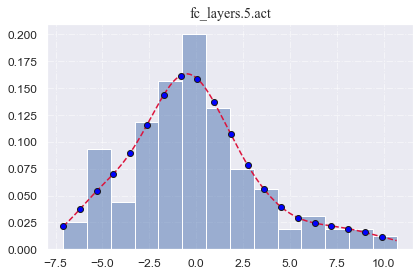

In [131]:
xlabel = "Expectation"
ylable = "Density"
import seaborn as sns
import os
sns.set()
from matplotlib.ticker import PercentFormatter

bin_num = 10


font_family = {'family': 'Times New Roman', 'size': 14}
font_size = {'ax_label': 24, 'ax_tick': 22, 'inner_tick': 14, 'text': 15, 'legend': 12}
line_args = {'marker': 'o', 'markevery': bin_num, 'ls': '--', 'mfc': 'blue', 'mec': 'k'}

sufix = 'quant' if quant else 'full-precision'
base_path = 'log/' + model_name + '/' + sufix + "/"

if not os.path.exists(base_path):
    os.makedirs(base_path)

def draw_handle(name, data):
    plt.clf()
    fig, ax = plt.subplots()
    # plt.hist(data)
    # ax = plt.subplot()
    binw = 1
    g = sns.histplot(data.flatten(), kde=True, fill=True, stat='probability', line_kws=line_args)
    g.lines[0].set_color('crimson')

    # STEM PLOT https://github.com/mwaskom/seaborn/issues/2344
    # points = g.lines[0].get_path().vertices
    # x, y = np.split(points, 2, 1)
    # x = x[np.arange(0, len(x), int(len(x)/bin_num))]
    # y = y[np.arange(0, len(y), int(len(y)/bin_num))]
    # plt.stem(x, y, linefmt ='g--', markerfmt='b')
    # STEM PLOT

    # sns.displot(data.flatten(), kde=True)
    # g = sns.kdeplot(data.flatten(), color='red', marker='o', markevery=10, linestyle=':')
    # g.yaxis.set_major_formatter(PercentFormatter(1 / binw))
    # sns.distplot(data.flatten(), kde=True, hist=False, norm_hist=True)
    # plt.hist(data.flatten(), density=True)
    # plt.xlabel(xlabel, fontdict=font_family)
    # plt.ylabel(ylable, fontdict=font_family)
    ax.set(ylabel=None)
    plt.grid(True, alpha=0.5, linestyle='-.')
    plt.title(name, fontdict=font_family)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    # plt.show()
    print(base_path + name + '.pdf')
    plt.savefig(base_path + name + '.pdf')

for name, param in model.named_parameters():
    # draw_handle(name.split('.')[0] + '.weight', param.data.numpy())
    # draw_handle(name.split('.')[0] + '.weight_grad', param.grad.numpy())

    draw_handle(name, param.data.numpy())
    draw_handle(name + '_grad', param.grad.numpy())

    # logger.add_histogram(name, param.data.numpy(), global_iter_num)
    # logger.add_histogram(name+"_grad", param.grad.numpy(), global_iter_num)
for name, module in model.named_modules():
    draw_handle(name + '.act', activations[name])

    # logger.add_histogram(name, activations[name], global_iter_num)